In [24]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

os.chdir(r"C:\Users\cgree\Documents\Astra\Space_weather5_22\weakley_all")

In [29]:
df = pd.read_csv('combined_csv.csv')
df.index = pd.to_datetime(df[['year','month','day' ,'hour','minute','second']])
df = df.drop(columns=["year", "month", "day", "hour", "minute", "second"])

In [30]:
df3 = pd.read_csv(r'C:\Users\cgree\Documents\Astra\Space_weather5_22\2018_sm_reg.csv')
df3 = df3.set_index('Date_UTC')

In [31]:
dfx = df.join(df3, how='inner')#  how='left')   #'inner')

## Data prep

In [32]:
dfx= dfx.replace([99999.9, 9999.99, 999.99, 999999.0 ,999999.00,-99999.990000, '#REF!'], np.nan)

In [33]:
del dfx['AE']

In [34]:
def calculate_derivative(df, new_column_name, column_to_derive, shift_in_date = 1):
    df[new_column_name] = (df[column_to_derive])-(df[column_to_derive].shift(1))/(shift_in_date)
    return df[new_column_name]

In [35]:
new_column_name = 'FOD' #first order derivative
column_to_derive = 'gic'
calculate_derivative(dfx, new_column_name, column_to_derive, shift_in_date = 1)

2018-03-01 00:00:00     NaN
2018-03-01 00:01:00    0.06
2018-03-01 00:02:00   -0.01
2018-03-01 00:03:00    0.02
2018-03-01 00:04:00    0.06
                       ... 
2018-03-31 23:55:00    0.04
2018-03-31 23:56:00    0.00
2018-03-31 23:57:00   -0.10
2018-03-31 23:58:00    0.11
2018-03-31 23:59:00   -0.15
Name: FOD, Length: 44579, dtype: float64

In [36]:
#second order derivative
new_column_name = 'SOD' #second order derivative
column_to_derive = 'FOD'
calculate_derivative(dfx, new_column_name, column_to_derive, shift_in_date = 1)

2018-03-01 00:00:00     NaN
2018-03-01 00:01:00     NaN
2018-03-01 00:02:00   -0.07
2018-03-01 00:03:00    0.03
2018-03-01 00:04:00    0.04
                       ... 
2018-03-31 23:55:00    0.12
2018-03-31 23:56:00   -0.04
2018-03-31 23:57:00   -0.10
2018-03-31 23:58:00    0.21
2018-03-31 23:59:00   -0.26
Name: SOD, Length: 44579, dtype: float64

In [37]:
#q table actions using the formula :

q_table[state][action] + alpha (reward + gamma np.max(q_table[next_state]) - q_table[state][action])

SyntaxError: invalid syntax (<ipython-input-37-80ef7cd4e555>, line 3)

In [38]:
prices = dfx['gic']
# del prices['index']
prices = prices.reset_index(drop=True)

# Building RL model

In [ ]:


def going_up(self, action):
    if action == 1: #data increasing
            self.positions.append(self.data.iloc[self.t, :]['gic'])
            reward -= .1
def going_up(self, action):
    if action == 2: #data decreasing
            self.positions.append(self.data.iloc[self.t, :]['gic'])
            reward -= .1
    
def going_up(self, action):
    if action == 0: #data stagnatnt
            self.positions.append(self.data.iloc[self.t, :]['gic'])
            reward -= 2

In [39]:
def buy(btc_price, btc, money):
    if(money != 0):
        btc = (1 / btc_price ) * money
        money = 0
    return btc, money


def sell(btc_price, btc, money):
    if(btc != 0):
        money = btc_price * btc
        btc = 0
    return btc, money


def wait(btc_price, btc, money):
    # do nothing
    return btc, money

In [40]:
np.random.seed(1)

# set of actions that the user could do
actions = { 'buy' : buy, 'sell': sell, 'wait' : wait}

actions_to_nr = { 'buy' : 0, 'sell' : 1, 'wait' : 2 }
nr_to_actions = { k:v for (k,v) in enumerate(actions_to_nr) }

nr_actions = len(actions_to_nr.keys())
nr_states = len(prices)

# q-table = reference table for our agent to select the best action based on the q-value
q_table = np.random.rand(nr_states, nr_actions)

In [41]:
def get_reward(before_btc, btc, before_money, money):
    reward = 0
    if(btc != 0):
        if(before_btc < btc):
            reward = 1
    if(money != 0):
        if(before_money < money):
            reward = 1
            
    return reward

In [42]:
def choose_action(state):
    if np.random.uniform(0, 1) < eps:
        return np.random.randint(0, 2)
    else:
        return np.argmax(q_table[state])

In [43]:
def take_action(state, action):
    return actions[nr_to_actions[action]](prices[state], btc, money)

In [44]:
def act(state, action, theta):
    btc, money = theta
    
    done = False
    new_state = state + 1
    
    before_btc, before_money = btc, money
    btc, money = take_action(state, action)
    theta = btc, money
    
    reward = get_reward(before_btc, btc, before_money, money)
    
    if(new_state == nr_states):
        done = True
    
    return new_state, reward, theta, done

In [45]:
reward = 0
btc = 0
money = 100

theta = btc, money

In [46]:
# exploratory
eps = 0.3

n_episodes = 20
min_alpha = 0.02

# learning rate for Q learning
alphas = np.linspace(1.0, min_alpha, n_episodes)

# discount factor, used to balance immediate and future reward
gamma = 1.0

In [47]:
rewards = {}

for e in range(n_episodes):
    
    total_reward = 0
    
    state = 0
    done = False
    alpha = alphas[e]
    
    while(done != True):

        action = choose_action(state)
        next_state, reward, theta, done = act(state, action, theta)
        
        total_reward += reward
        
        if(done):
            rewards[e] = total_reward
            print(f"Episode {e + 1}: total reward -> {total_reward}")
            break
        
        #q formulat
        q_table[state][action] = q_table[state][action] + alpha * (reward + gamma *  np.max(q_table[next_state]) - q_table[state][action])

        state = next_state

<ipython-input-39-cc2982cd9a7f>:3: RuntimeWarning: divide by zero encountered in double_scalars
  btc = (1 / btc_price ) * money


Episode 1: total reward -> 19213
Episode 2: total reward -> 21074
Episode 3: total reward -> 21592
Episode 4: total reward -> 22163
Episode 5: total reward -> 22652
Episode 6: total reward -> 23130
Episode 7: total reward -> 23551
Episode 8: total reward -> 23671
Episode 9: total reward -> 23960
Episode 10: total reward -> 23986
Episode 11: total reward -> 24112
Episode 12: total reward -> 24167
Episode 13: total reward -> 24126
Episode 14: total reward -> 24159
Episode 15: total reward -> 24361
Episode 16: total reward -> 24225
Episode 17: total reward -> 24261
Episode 18: total reward -> 24222
Episode 19: total reward -> 24366
Episode 20: total reward -> 24276


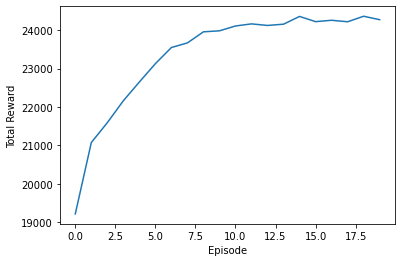

In [53]:
plt.ylabel('Total Reward')
plt.xlabel('Episode')
plt.plot([rewards[e] for e in rewards.keys()])
plt.show()

In [54]:
state = 0
acts = np.zeros(nr_states)
done = False

while(done != True):

        action = choose_action(state)
        next_state, reward, theta, done = act(state, action, theta)
        
        acts[state] = action
        
        total_reward += reward
        
        if(done):
            break
            
        state = next_state

<ipython-input-39-cc2982cd9a7f>:3: RuntimeWarning: divide by zero encountered in double_scalars
  btc = (1 / btc_price ) * money


In [55]:
buys_idx = np.where(acts == 0)
wait_idx = np.where(acts == 2)
sell_idx = np.where(acts == 1)

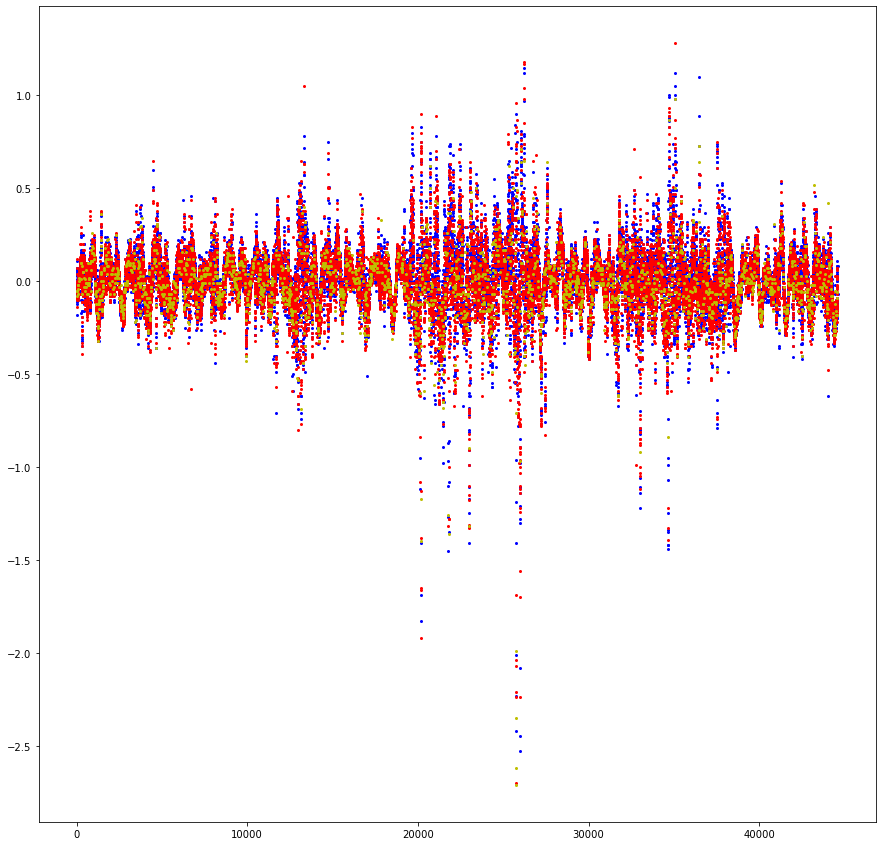

In [56]:
plt.figure(figsize=(15,15))
plt.plot(buys_idx[0], prices[buys_idx[0]], 'bo', markersize=2)
plt.plot(sell_idx[0], prices[sell_idx[0]], 'ro', markersize=2)
plt.plot(wait_idx[0], prices[wait_idx[0]], 'yo', markersize=2)

In [ ]:
# Deep Q-Network

def train_dqn(env):

    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            y = self.fc3(h)
            return y

        def reset(self):
            self.zerograds()

    Q = Q_Network(input_size=env.history_t+1, hidden_size=100, output_size=3)
    Q_ast = copy.deepcopy(Q)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q)

    epoch_num = 1000
    step_max = len(env.data)-1
    memory_size = 300
    batch_size = 20
    epsilon = 1.0
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 20
    gamma = 0.97
    show_log_freq = 5

    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []

    start = time.time()
    for epoch in range(epoch_num):

        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0

        while not done and step < step_max:

            # select act
            pact = np.random.randint(3)
            if np.random.rand() > epsilon:
                pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                pact = np.argmax(pact.data)

            # act
            obs, reward, done = env.step(pact)

            # add memory
            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)

            # train or update q
            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    shuffled_memory = np.random.permutation(memory)
                    memory_idx = range(len(shuffled_memory))
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size])
                        b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                        q = Q(b_pobs)
                        maxq = np.max(Q_ast(b_obs).data, axis=1)
                        target = copy.deepcopy(q.data)
                        for j in range(batch_size):
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                        Q.reset()
                        loss = F.mean_squared_error(q, target)
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()

                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)

            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            elapsed_time = time.time()-start
            print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss, elapsed_time])))
            start = time.time()
            
    return Q, total_losses, total_rewards